In [1]:
import pandas

In [6]:
import os
import pandas as pd

csv_files = [f for f in os.listdir('..') if f.endswith('.csv')]

for file in csv_files:
    df_name = f"df_{os.path.splitext(file)[0]}"
    globals()[df_name] = pd.read_csv(os.path.join('..', file))


In [12]:
from src.utils.dataframe_info import print_dataframe_shapes

print_dataframe_shapes(
    matrixXNirSpectrumData=df_matrixXNirSpectrumData,
    matrixXNirSpectrumDataAxis=df_matrixXNirSpectrumDataAxis,
    matrixXNirSpectrumDerivative=df_matrixXNirSpectrumDerivative,
    matrixXNirSpectrumDerivativeAxis=df_matrixXNirSpectrumDerivativeAxis,
    matrixYNirPropertyDensityNormalized=df_matrixYNirPropertyDensityNormalized
)


matrixXNirSpectrumData: (2634, 208)
matrixXNirSpectrumDataAxis: (2634, 1)
matrixXNirSpectrumDerivative: (2593, 208)
matrixXNirSpectrumDerivativeAxis: (2593, 1)
matrixYNirPropertyDensityNormalized: (0, 208)


In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# For demonstration, assume that our data files are stored as CSV files.
# Adjust the file names and paths as appropriate.
data_dir = ".."  # Change this if your files are in a different folder

# Define file paths
file_X = os.path.join(data_dir, "matrixXNirSpectrumData.csv")
file_X_axis = os.path.join(data_dir, "matrixXNirSpectrumDataAxis.csv")
file_deriv = os.path.join(data_dir, "matrixXNirSpectrumDerivative.csv")
file_deriv_axis = os.path.join(data_dir, "matrixXNirSpectrumDerivativeAxis.csv")
file_y = os.path.join(data_dir, "matrixYNirPropertyDensityNormalized.csv")

# Load the data using pandas (or numpy, as appropriate)
try:
    X = pd.read_csv(file_X, header=None).values  # shape: (2634, 208)
    X_axis = pd.read_csv(file_X_axis, header=None).values  # shape: (2634, 1)
    X_deriv = pd.read_csv(file_deriv, header=None).values  # shape: (2593, 208)
    X_deriv_axis = pd.read_csv(file_deriv_axis, header=None).values  # shape: (2593, 1)
    y = pd.read_csv(file_y, header=None).values  # shape: (0, 208) expected!
except Exception as e:
    print("Error while loading data files:", e)

# Print shapes for verification
print("Raw NIR Spectrum Data shape:", X.shape)
print("Raw Spectrum Axis shape:", X_axis.shape)
print("Derivative Spectrum Data shape:", X_deriv.shape)
print("Derivative Spectrum Axis shape:", X_deriv_axis.shape)
print("Response (Normalized Property Density) shape:", y.shape)


Raw NIR Spectrum Data shape: (2635, 208)
Raw Spectrum Axis shape: (2635, 1)
Derivative Spectrum Data shape: (2594, 208)
Derivative Spectrum Axis shape: (2594, 1)
Response (Normalized Property Density) shape: (1, 208)


## Data Inspection and Visualization

Let's inspect one sample from the raw spectrum and its derivative. In many spectral applications, the x-axis represents wavelengths.


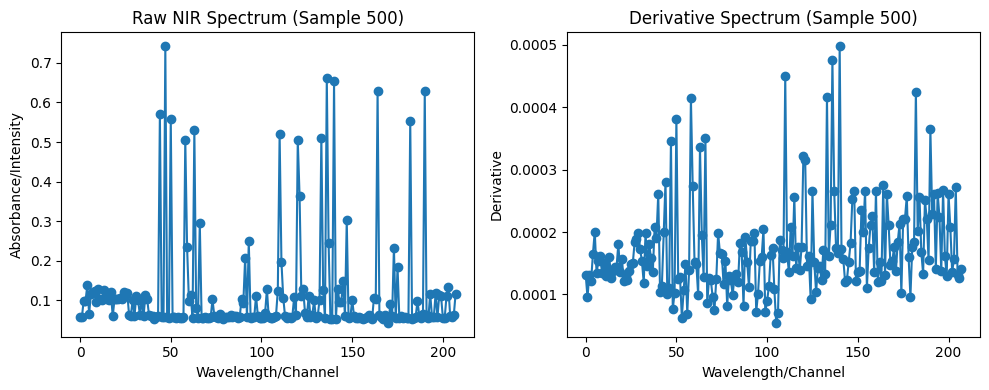

In [17]:
# Plot a sample raw spectrum and its derivative (if available)
sample_idx = 500  # For example, plot the first sample

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# If X_axis is provided as a (2634,1) array, one might assume one common axis.
# Here, we will simply use a range if the axis is not informative.
x_vals = np.arange(X.shape[1])
plt.plot(x_vals, X[sample_idx, :], '-o')
plt.title("Raw NIR Spectrum (Sample {})".format(sample_idx))
plt.xlabel("Wavelength/Channel")
plt.ylabel("Absorbance/Intensity")

plt.subplot(1, 2, 2)
x_deriv_vals = np.arange(X_deriv.shape[1])
plt.plot(x_deriv_vals, X_deriv[sample_idx % X_deriv.shape[0], :], '-o')
plt.title("Derivative Spectrum (Sample {})".format(sample_idx))
plt.xlabel("Wavelength/Channel")
plt.ylabel("Derivative")
plt.tight_layout()
plt.show()


## Applying Dual-sPLS Regression

The dual-sPLS method is designed to perform regression when you have many predictors (e.g., 208 wavelength channels).  
Our Python implementation of dual-sPLS is available as a package (with modules such as `dual_spls.lasso`, `dual_spls.pls`, etc.).  



In [ ]:
y_dummy = y[:, 0]
    
print("Using response vector shape:", y_dummy.shape)


Using response vector shape: [0.53670394]


### Running Dual-sPLS

For this demonstration we will use one of the implemented dual-sPLS methods, for example the LASSO version.  
Make sure your dual-sPLS modules are in your Python path (for example in a package called `dual_spls`).

Below, we run the dual-sPLS LASSO method. You may adjust the parameters (`ncp` for number of components, `ppnu` as a sparsity parameter, etc.) as needed.


In [41]:
X.shape, X_axis.shape

((2635, 208), (2635, 1))

In [62]:
# Import the dual-sPLS LASSO function from your package
# (Make sure the package is installed/available in your PYTHONPATH)
from dual_spls.lasso import d_spls_lasso

# Set model parameters
ncp = 5     # number of components
ppnu = 0.9  # sparsity parameter (adjust as needed)


model = d_spls_lasso(X.T, y, ncp=ncp, ppnu=ppnu, verbose=True)

# Display some model attributes
print("Model type:", model.get('type', 'unknown'))
print("Intercepts:", model['intercept'])
print("Shape of coefficient matrix (Bhat):", model['Bhat'].shape)


Dual PLS ic=1, lambda=0.3944, mu=39.2365, nu=15.4736, nbzeros=2372
Dual PLS ic=2, lambda=0.1282, mu=8.1344, nu=1.0426, nbzeros=2109
Dual PLS ic=3, lambda=0.3348, mu=2.4466, nu=0.8192, nbzeros=1846
Dual PLS ic=4, lambda=5.9778, mu=0.0120, nu=0.0720, nbzeros=1583
Dual PLS ic=5, lambda=0.0646, mu=0.2159, nu=0.0139, nbzeros=1435
Model type: lasso
Intercepts: [0.4541927  1.32322935 2.86496942 1.93659181 1.74787738]
Shape of coefficient matrix (Bhat): (2635, 5)


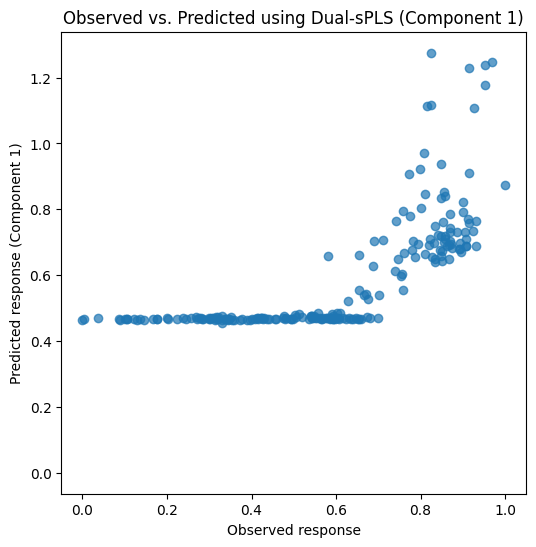

In [66]:
# Import the prediction function
from dual_spls.predict import d_spls_predict

y_pred = d_spls_predict(model, X.T)

# For demonstration, plot observed vs predicted values for the first component
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred[:, 0], alpha=0.7)
plt.xlabel("Observed response")
plt.ylabel("Predicted response (Component 1)")
plt.title("Observed vs. Predicted using Dual-sPLS (Component 1)")
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.show()
